PART1: Preliminary Data Analysis

In [1]:
# Import all required modules
# Disable warnings
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/" + "mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


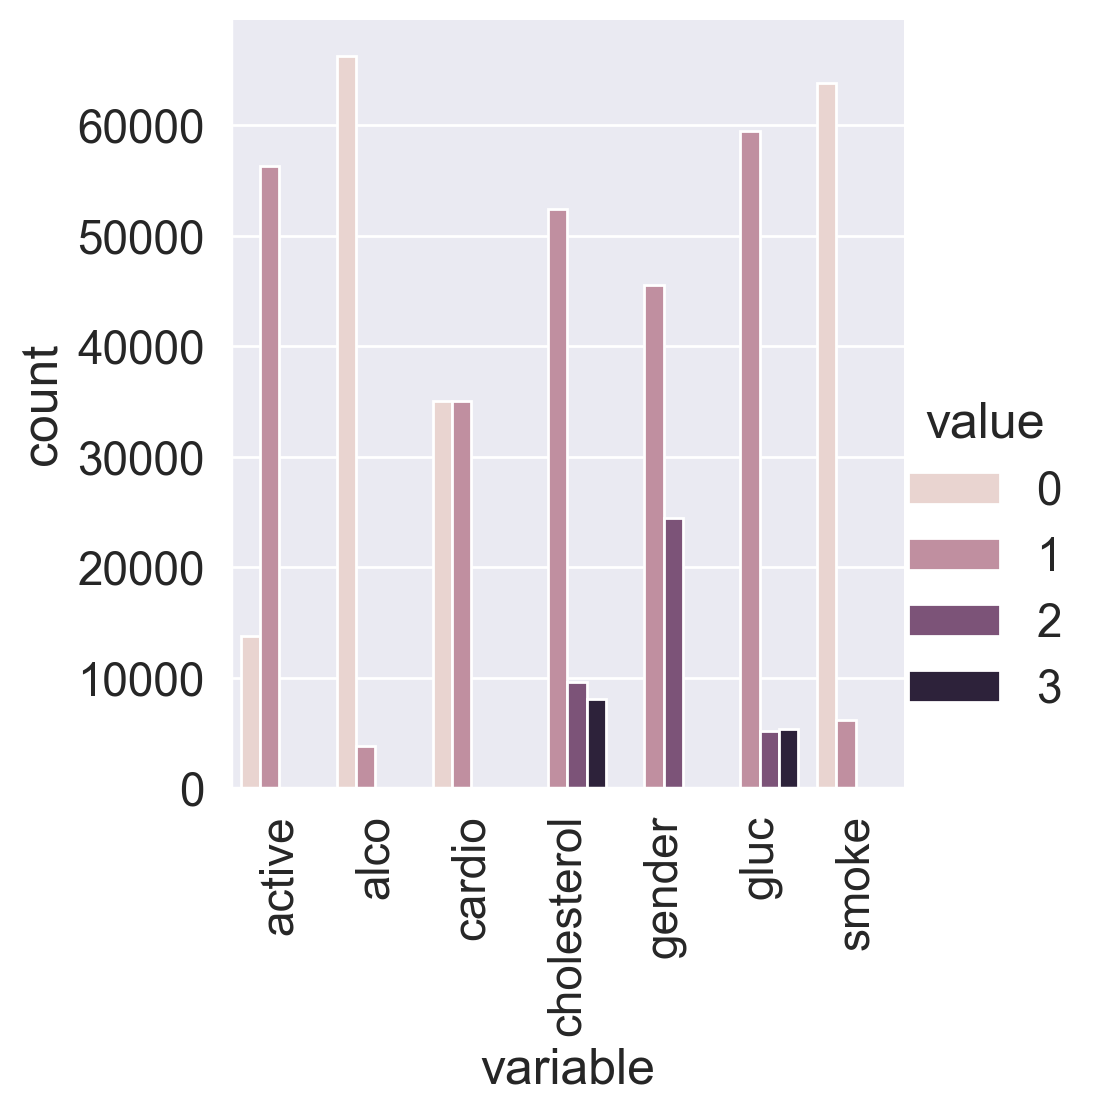

In [4]:
#converting data into long format using catplot()

df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar"
)
plt.xticks(rotation='vertical');

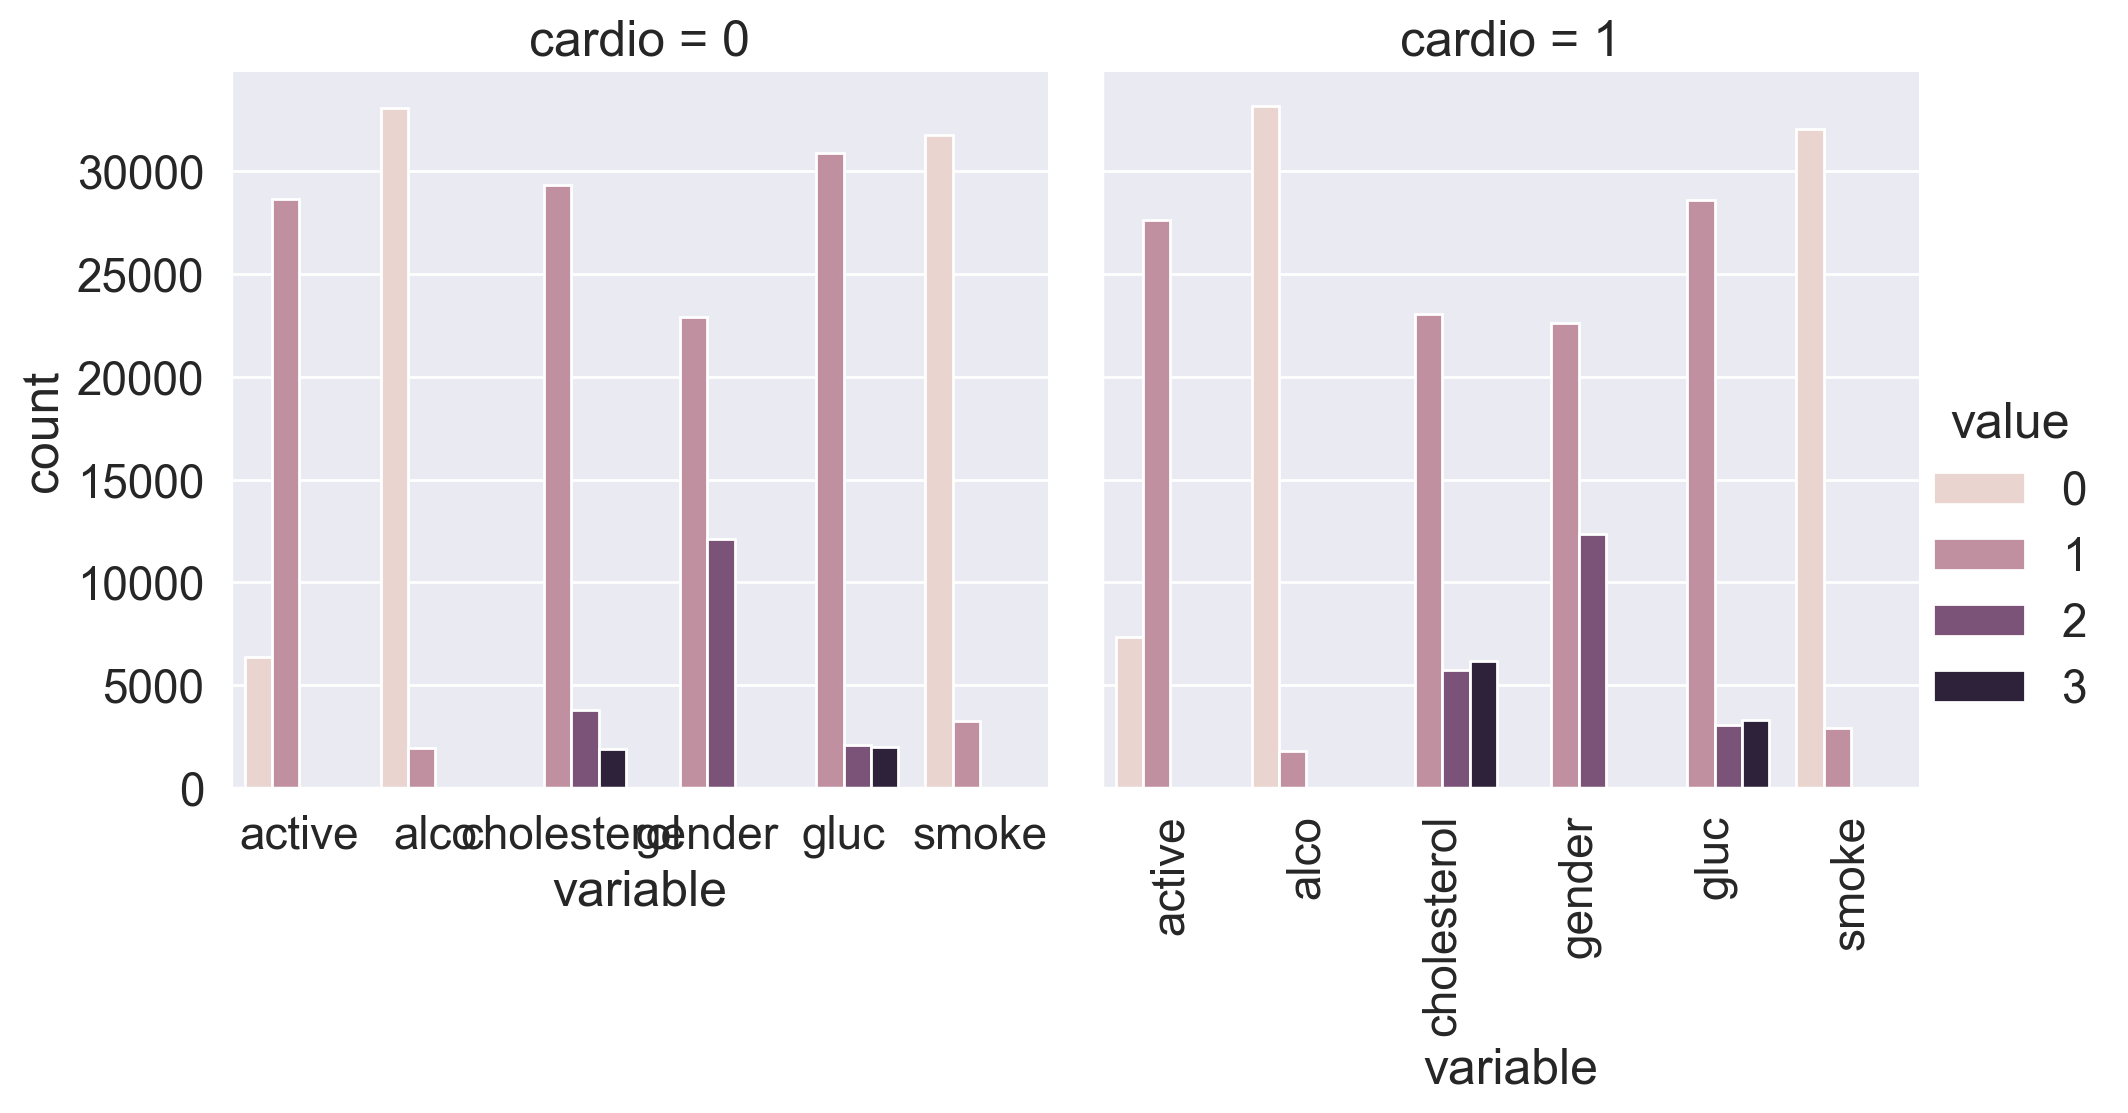

In [5]:
#splitting dataset by target values

df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
)
plt.xticks(rotation='vertical');

In [6]:
#glucose and cholesterol levels are the most important features 
#statistics for feature unique values

for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")


id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


BASIC OBSERVATIONS

Q1: How many men and women are present in this dataset? Values of the gender feature were not given (whether “1” stands for women or for men) – figure this out by analyzing height, making the assumption that men are taller on average.

A1: 24470 men (2) and 45530 women (1)

Q2: Who more often report consuming alcohol – men or women?

In [7]:
#A2: Men

df.groupby("gender")["height"].mean()

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

Q3: What’s the rounded difference between the percentages of smokers among men and women?

In [8]:
df.groupby("gender")["smoke"].mean()

gender
1    0.017856
2    0.218880
Name: smoke, dtype: float64

In [9]:
round(
    100
    * (
        df.loc[df["gender"] == 2, "smoke"].mean()
        - df.loc[df["gender"] == 1, "smoke"].mean()
    )
)

20

Q4: What’s the rounded difference between median values of age (in months) for non-smokers and smokers? You’ll need to figure out the units of feature age in this dataset.

In [10]:
df.groupby("smoke")["age"].median() / 365.25

smoke
0    53.995893
1    52.361396
Name: age, dtype: float64

In [11]:
#median age for smokers: 52.4 years
#median age for non-smokers: 54 years

(
    df[df["smoke"] == 0]["age"].median() - df[df["smoke"] == 1]["age"].median()
) / 365.25 * 12

np.float64(19.613963039014372)

A4: 20 months

RISK MAPS

Q5: Calculate fractions of ill people (with CVD) in the two groups of people described in the task. What’s the ratio of these two fractions?

In [12]:
df["age_years"] = (df["age"] / 365.25).round().astype("int")
df["age_years"].max()

np.int64(65)

In [13]:
#oldest person in the dataset is 65 years old
smoking_old_men = df[
    (df["gender"] == 2)
    & (df["age_years"] >= 60)
    & (df["age_years"] < 65)
    & (df["smoke"] == 1)
]

smoking_old_men[
    (smoking_old_men["cholesterol"] == 1) & (smoking_old_men["ap_hi"] < 120)
]["cardio"].mean()

np.float64(0.2631578947368421)

In [14]:
#proportion of people with CVD is 26% 
#however, cholesterol level in this age group is 3

smoking_old_men[
    (smoking_old_men["cholesterol"] == 3)
    & (smoking_old_men["ap_hi"] >= 160)
    & (smoking_old_men["ap_hi"] < 180)
]["cardio"].mean()
#proportion of people with CVD is 86%

np.float64(0.8636363636363636)

ANALYZING BMI

Q6: CHOOSE THE CORRECT STATEMENTS

In [15]:
df["BMI"] = df["weight"] / (df["height"] / 100) ** 2

In [16]:
df["BMI"].median()

np.float64(26.374068120774975)

In [20]:
#BMI numbers surpass 25, as such sample not within normal values
df.groupby("gender")["BMI"].median()

gender
1    26.709402
2    25.910684
Name: BMI, dtype: float64

In [19]:
#women's (1) BMI is higher than men's (2)
df.groupby(["gender", "alco", "cardio"])["BMI"].median().to_frame()

BMI
gender alco cardio           
1      0    0       25.654372
            1       27.885187
       1    0       27.885187
            1       30.110991
2      0    0       25.102391
            1       26.674874
       1    0       25.351541
            1       27.530797

In [21]:
#when alco=0 and cardio=0, bmi values are healthier

A6: 
Women’s BMI is on average higher than men’s.
In the segment of healthy and non-drinking men BMI is closer to the norm than in the segment of healthy and non-drinking women

CLEANING DATA

Q7: What percent of the original data (rounded) did we filter out in the previous step?

In [22]:
df_to_remove = df[
    (df["ap_lo"] > df["ap_hi"])
    | (df["height"] < df["height"].quantile(0.025))
    | (df["height"] > df["height"].quantile(0.975))
    | (df["weight"] < df["weight"].quantile(0.025))
    | (df["weight"] > df["weight"].quantile(0.975))
]
print(df_to_remove.shape[0] / df.shape[0])

filtered_df = df[~df.index.isin(df_to_remove)]

0.0963


A7: 3 - 10%

PART 2- VISUAL DATA ANALYSIS

Plot a correlation matrix using heatmap(). You can create the matrix using the standard pandas tools with the default parameters.

Q1: Which pair of features has the strongest Pearson’s correlation with the gender feature?

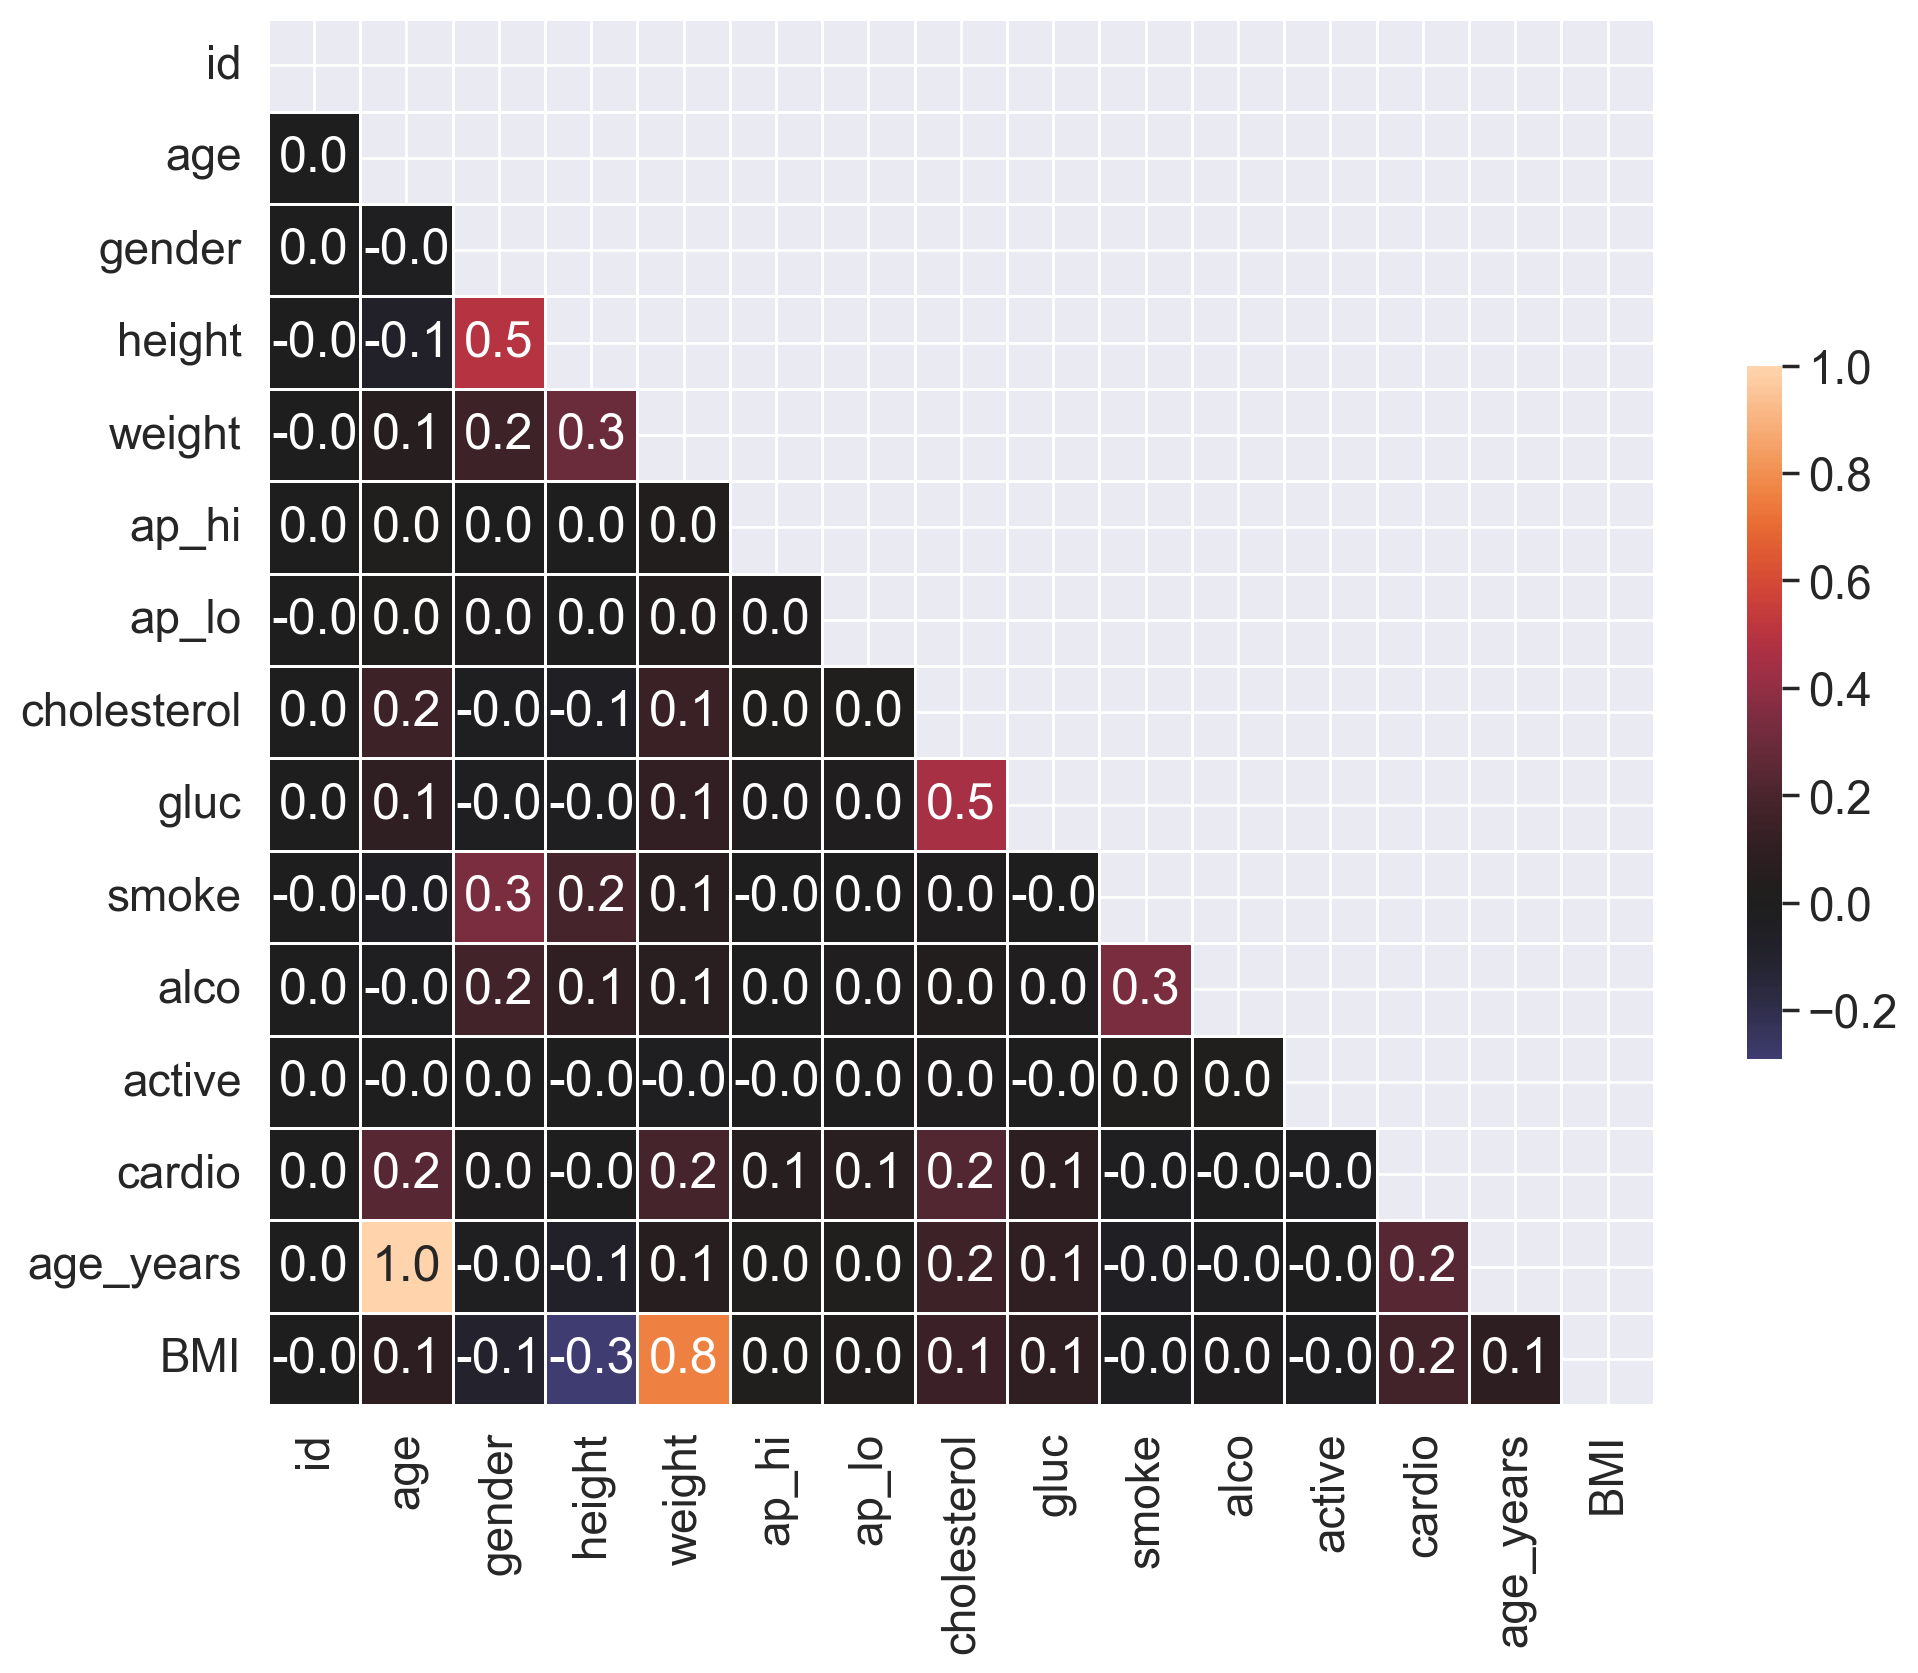

In [ ]:
# orrelation matrix
df = filtered_df.copy()

corr = df.corr(method="pearson")

# mask to hide the upper triangle of the correlation matrix
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(
    corr,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".1f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

A1: 2- height, smoke

Height distribution of men and women

Create a violin plot for the height and gender using violinplot(). Use the parameters:

hue to split by gender;

scale to evaluate the number of records for each gender.

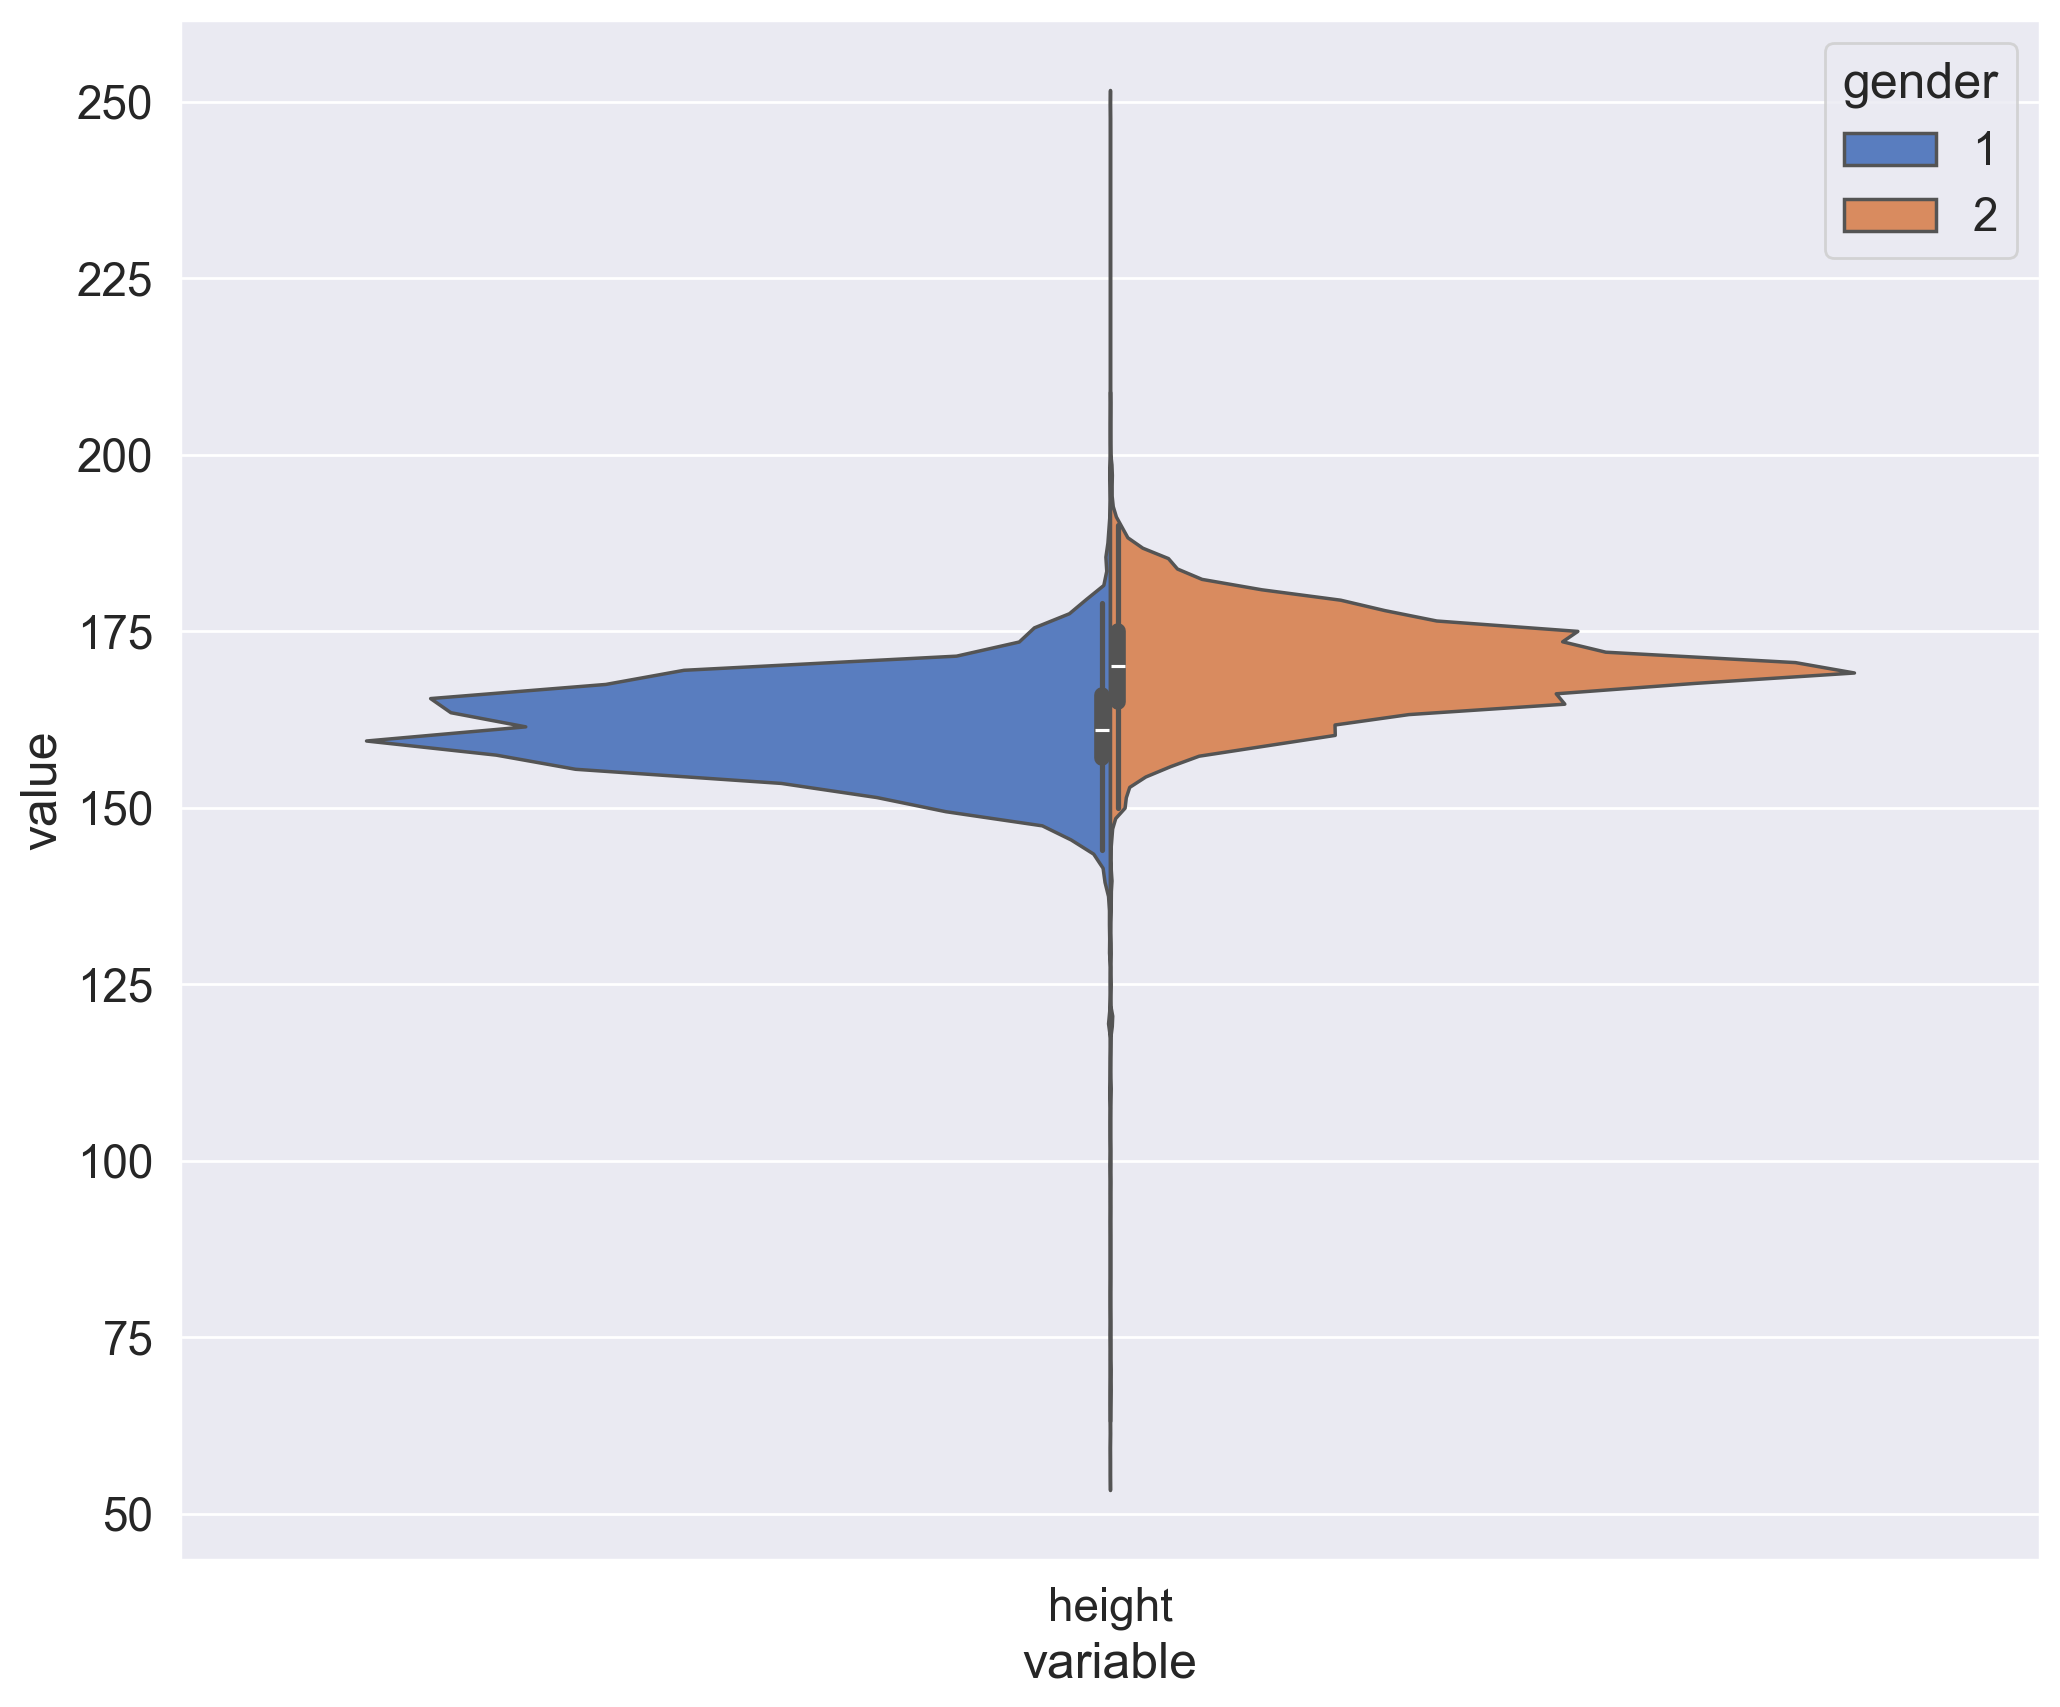

In [24]:
df_melt = pd.melt(frame=df, value_vars=["height"], id_vars=["gender"])

plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x="variable",
    y="value",
    hue="gender",
    palette="muted",
    split=True,
    data=df_melt,
    scale="count",
    scale_hue=False,
)

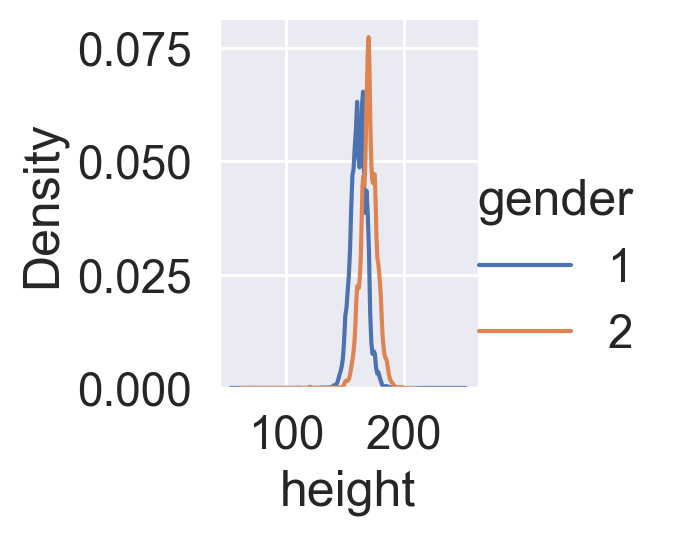

In [25]:
sns.FacetGrid(df, hue="gender").map(sns.kdeplot, "height").add_legend();

RANK CORRELATION

Calculate and plot a correlation matrix using the Spearman’s rank correlation coefficient.

Q2:  Which pair of features has the strongest Spearman rank correlation?

Q3: Why do these features have strong rank correlation?

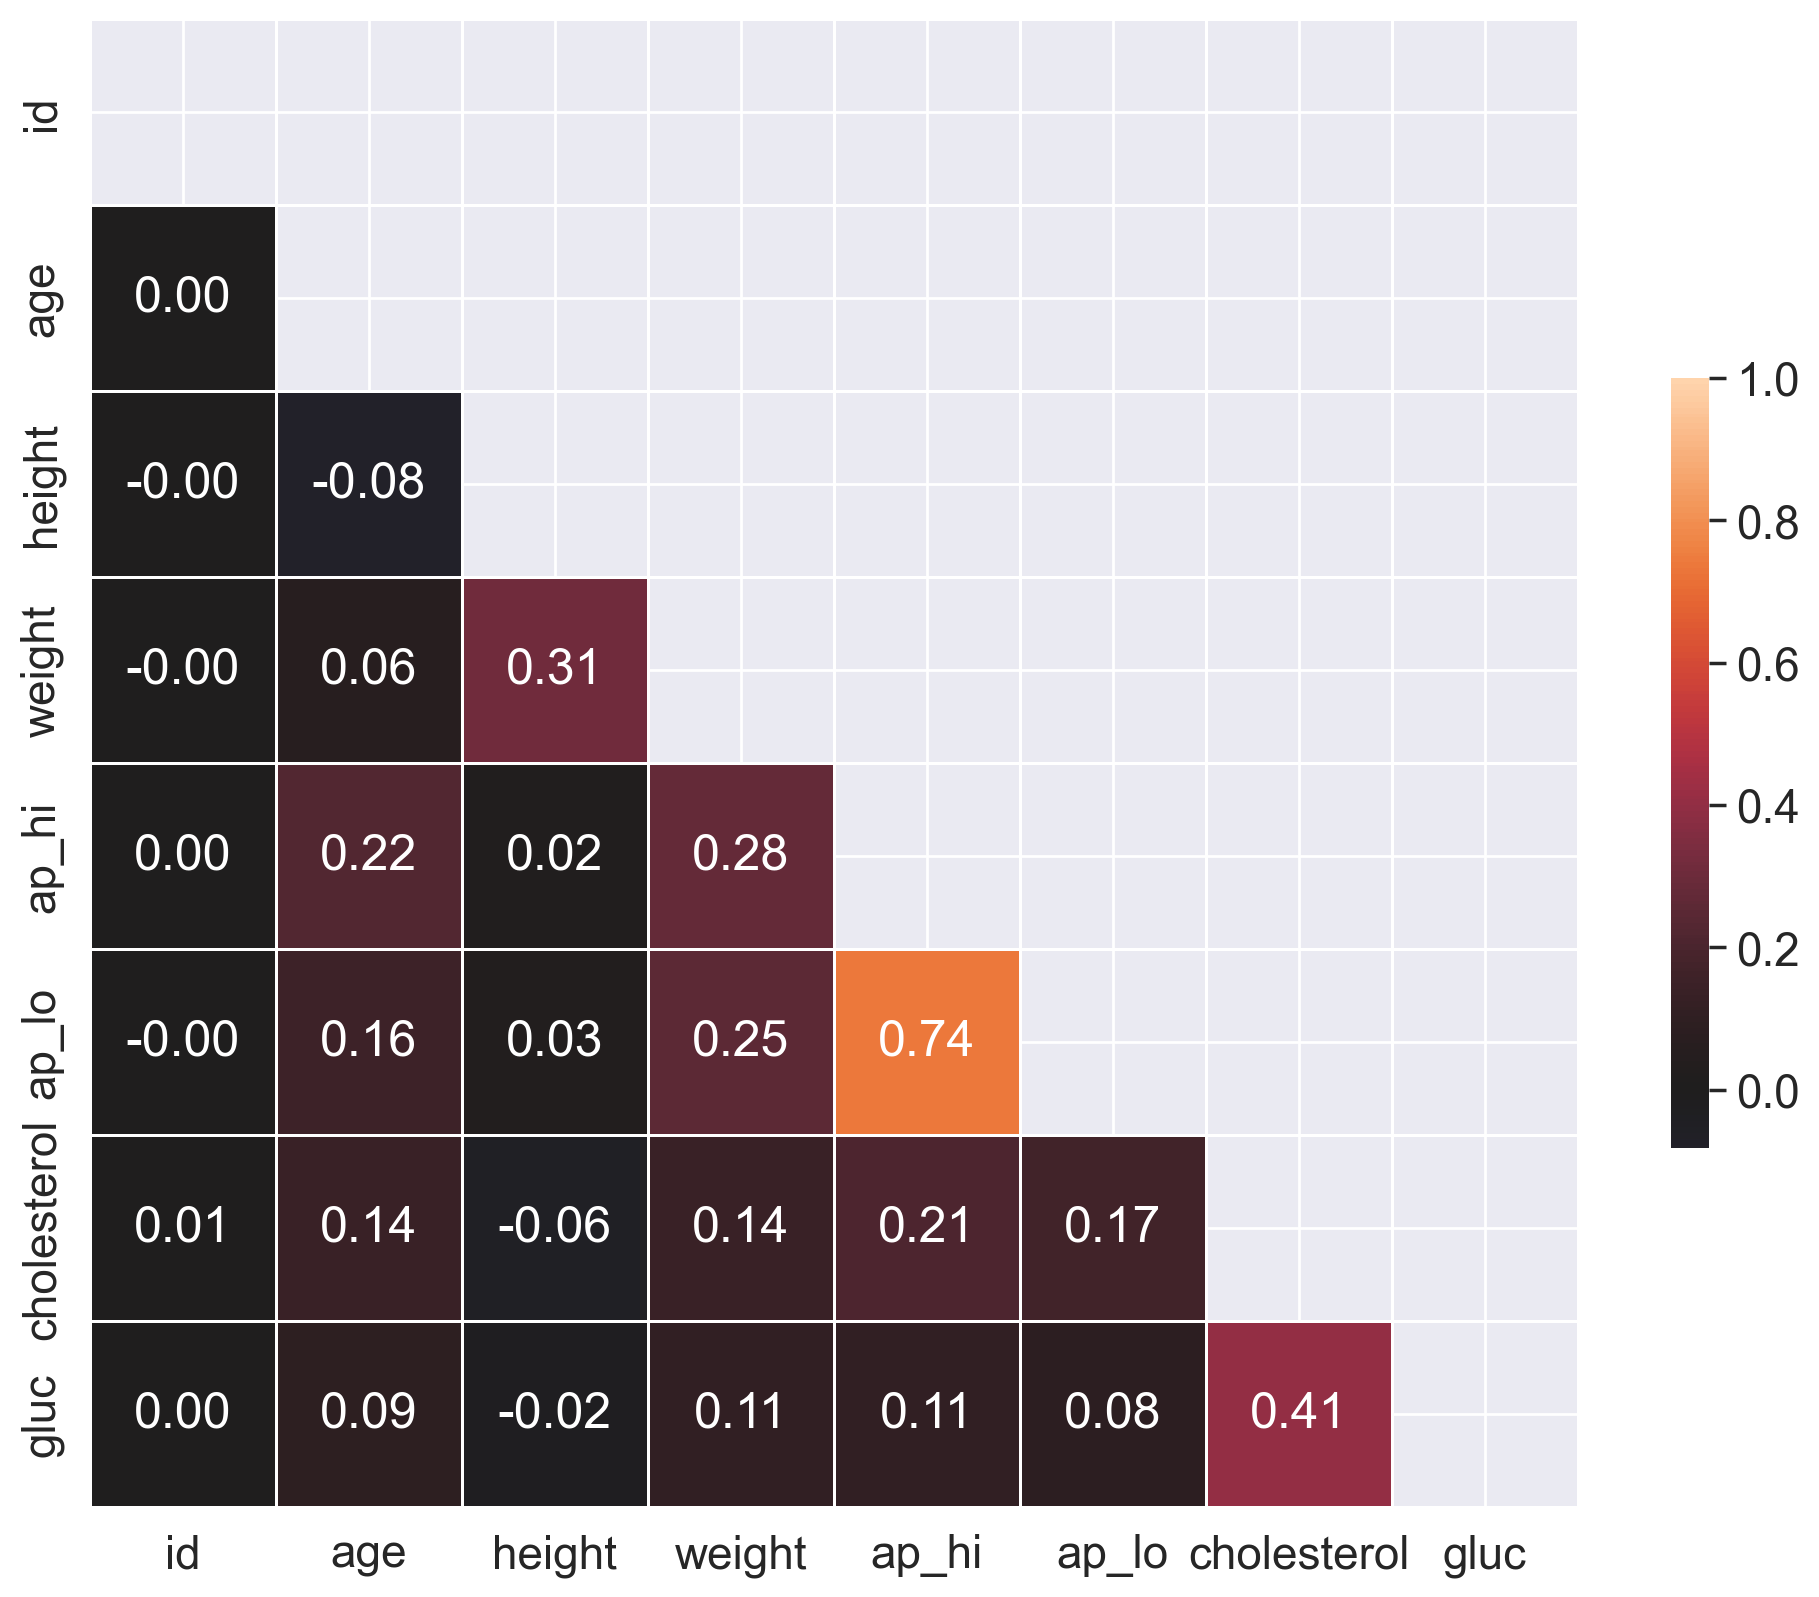

In [ ]:
# correlation
corr = df[
    ["id", "age", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc"]
].corr(method="spearman")

# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap using the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

A2: 5, ap_hi and ap_lo
A3: 3. nature of the data

AGE

Create a count plot using countplot() with the age on the X axis and the number of people on the Y axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each cardio class of that age

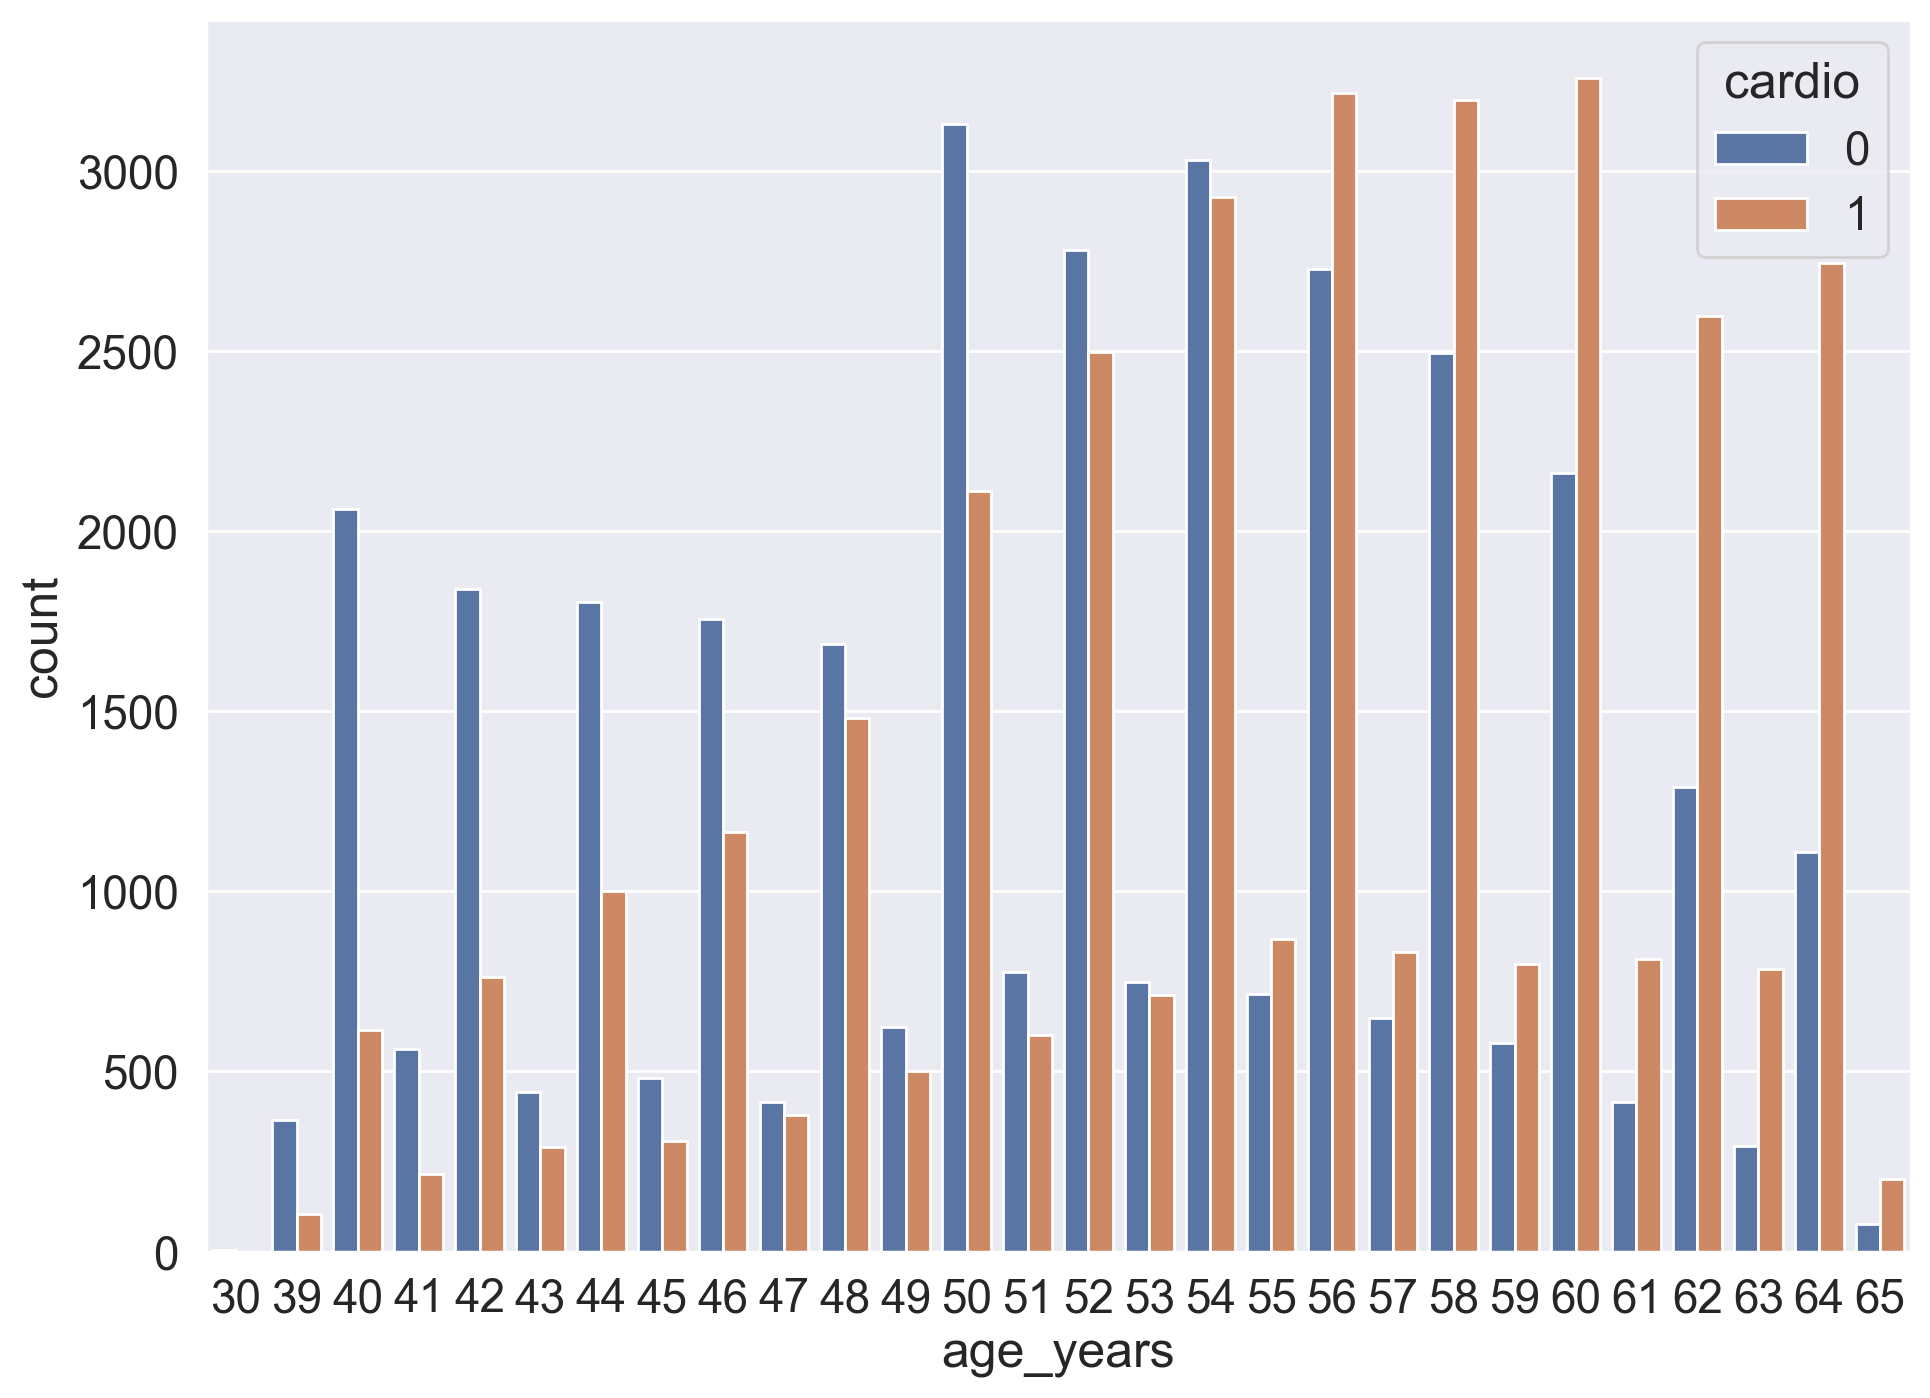

In [27]:
sns.countplot(x="age_years", hue="cardio", data=df);

Q4: What is the smallest age at which the number of people with CVD outnumbers the number of people without CVD?

A4: 55